In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as smapi
import datetime

import warnings
warnings.filterwarnings("ignore")

In [5]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

In [6]:
# Load the data
amazon_df = pd.read_csv('Amazon_stock.csv', header=0, parse_dates=[0], date_parser=parser)

In [7]:
amazon_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-07-30,16.0725,16.136499,15.9250,16.1255,16.1255,79380000
1,2014-07-31,16.0005,16.034000,15.5930,15.6495,15.6495,103840000
2,2014-08-01,15.6845,15.791500,15.2295,15.3530,15.3530,148830000
3,2014-08-04,15.4420,15.809000,15.4250,15.6825,15.6825,84018000
4,2014-08-05,15.6650,15.727500,15.5030,15.6160,15.6160,57042000


In [8]:
amazon_df[['Date', 'Close']].head(10)

,Date,Close
0,2014-07-30,16.1255
1,2014-07-31,15.6495
2,2014-08-01,15.3530
3,2014-08-04,15.6825
4,2014-08-05,15.6160
5,2014-08-06,15.6945
6,2014-08-07,15.5725
7,2014-08-08,15.8400
8,2014-08-11,15.9165
9,2014-08-12,15.9660


In [9]:
print('There are {} number of days in the dataset.'.format(amazon_df.shape[0]))

There are 2516 number of days in the dataset.


In [10]:
# Handle missing values
amazon_data = amazon_df.dropna()

In [11]:
amazon_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-07-30,16.072500,16.136499,15.925000,16.125500,16.125500,79380000
1,2014-07-31,16.000500,16.034000,15.593000,15.649500,15.649500,103840000
2,2014-08-01,15.684500,15.791500,15.229500,15.353000,15.353000,148830000
3,2014-08-04,15.442000,15.809000,15.425000,15.682500,15.682500,84018000
4,2014-08-05,15.665000,15.727500,15.503000,15.616000,15.616000,57042000
...,...,...,...,...,...,...,...
2511,2024-07-23,184.100006,189.389999,183.559998,186.410004,186.410004,47537700
2512,2024-07-24,183.199997,185.449997,180.410004,180.830002,180.830002,41532400
2513,2024-07-25,182.910004,183.899994,176.800003,179.850006,179.850006,44464200
2514,2024-07-26,180.389999,183.190002,180.240005,182.500000,182.500000,29506000


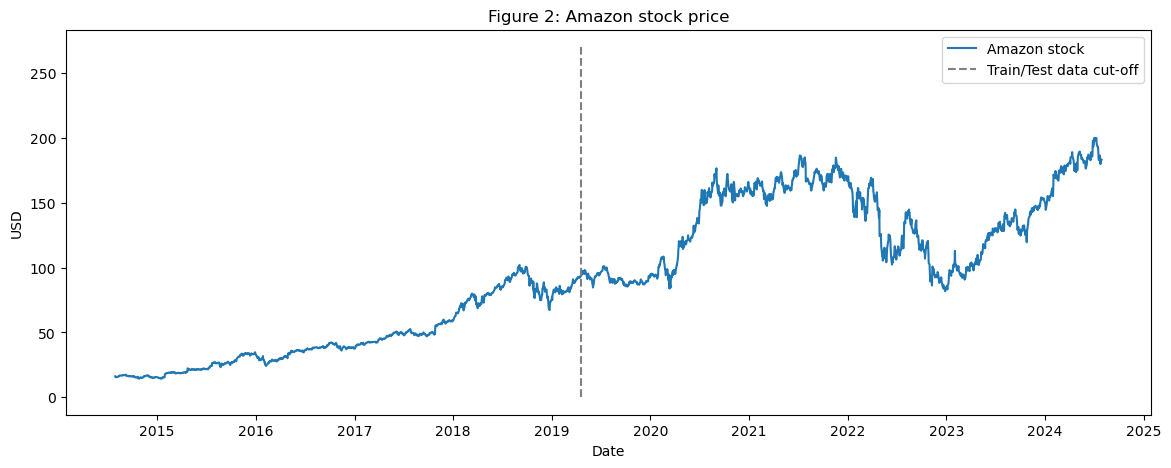

In [12]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(amazon_data['Date'], amazon_data['Close'], label='Amazon stock')
plt.vlines(datetime.date(2019,4,20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Amazon stock price')
plt.legend()
plt.show()

Generate Technical Indicators

Technical Indicator Calculation

In [13]:
# Define a function to calculate the Simple Moving Average (SMA)
def calculate_SMA(data, window):
    return data.rolling(window=window).mean()

amazon_data['SMA_50'] = calculate_SMA(amazon_data['Close'], 50)
amazon_data['SMA_200'] = calculate_SMA(amazon_data['Close'], 200)

In [14]:
# Define a function to calculate the Exponential Moving Average (EMA)
def calculate_ema(data, window):
    return data.ewm(span=window, adjust=False).mean()

amazon_data['EMA_50'] = calculate_ema(amazon_data['Close'], 50)

In [15]:
amazon_data['ema'] = amazon_data['Close'].ewm(com=0.5).mean()

In [16]:
# Define a function to calculate the Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = calculate_ema(data, short_window)
    long_ema = calculate_ema(data, long_window)
    macd = short_ema - long_ema
    signal = calculate_ema(macd, signal_window)
    return macd, signal

amazon_data['MACD'], amazon_data['MACD_Signal'] = calculate_macd(amazon_data['Close'], 12, 26, 9)

In [17]:
# Define a function to calculate the Bollinger Bands
def calculate_bollinger_bands(data, window, num_of_std):
    sma = calculate_SMA(data, window)
    std = data.rolling(window=window).std()
    upper_band = sma + (std * num_of_std)
    lower_band = sma - (std * num_of_std)
    return sma, upper_band, lower_band

amazon_data['BB_Mid'], amazon_data['BB_Upper'], amazon_data['BB_Lower'] = calculate_bollinger_bands(amazon_data['Close'], 20, 2)

In [18]:
# Define a function to calculate the Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

amazon_data['RSI_14'] = calculate_rsi(amazon_data['Close'], 14)

In [19]:
# Calculate the Momentum
amazon_data['momentum'] = (amazon_data['Close']/100)-1

In [20]:
# Display the first few rows with the new indicators
amazon_TI_data = amazon_data
amazon_TI_data

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_50,SMA_200,EMA_50,ema,MACD,MACD_Signal,BB_Mid,BB_Upper,BB_Lower,RSI_14,momentum
0,2014-07-30,16.072500,16.136499,15.925000,16.125500,16.125500,79380000,NaN,NaN,16.125500,16.125500,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.838745
1,2014-07-31,16.000500,16.034000,15.593000,15.649500,15.649500,103840000,NaN,NaN,16.106833,15.768500,-0.037972,-0.007594,NaN,NaN,NaN,NaN,-0.843505
2,2014-08-01,15.684500,15.791500,15.229500,15.353000,15.353000,148830000,NaN,NaN,16.077271,15.480846,-0.090941,-0.024264,NaN,NaN,NaN,NaN,-0.846470
3,2014-08-04,15.442000,15.809000,15.425000,15.682500,15.682500,84018000,NaN,NaN,16.061790,15.616962,-0.105120,-0.040435,NaN,NaN,NaN,NaN,-0.843175
4,2014-08-05,15.665000,15.727500,15.503000,15.616000,15.616000,57042000,NaN,NaN,16.044308,15.616318,-0.120336,-0.056415,NaN,NaN,NaN,NaN,-0.843840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,2024-07-23,184.100006,189.389999,183.559998,186.410004,186.410004,47537700,187.497000,166.49015,187.848748,185.284012,-0.737536,1.129395,193.1655,205.289012,181.041988,25.495871,0.864100
2512,2024-07-24,183.199997,185.449997,180.410004,180.830002,180.830002,41532400,187.364001,166.76450,187.573503,182.314672,-1.342010,0.635114,192.8900,205.885641,179.894359,22.880277,0.808300
2513,2024-07-25,182.910004,183.899994,176.800003,179.850006,179.850006,44464200,187.229600,167.02395,187.270621,180.671561,-1.878483,0.132395,192.2020,206.435156,177.968844,15.812703,0.798500
2514,2024-07-26,180.389999,183.190002,180.240005,182.500000,182.500000,29506000,187.138200,167.29515,187.083538,181.890520,-2.065994,-0.307283,191.4345,206.035983,176.833017,23.272845,0.825000


Technical Indicator Descriptions

Simple Moving Average (SMA): Average of closing prices over a specified period (e.g., 7 and 28 days).

EMA: Exponential moving average is a better version of a simple moving average that doesnt have SMAs lag. Moving averages just average out the data for a given time so we know how the company's closing price are trending for a given amount of days. example for 4 days is price was 22,23 ,45,1 (the company crashed on 4th day) the average would be 23

Moving Average Convergence Divergence (MACD): A trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.

Bollinger Bands: A volatility indicator that consists of a middle band (SMA) and two outer bands (standard deviations away from the middle band).

.

EXPLORATORY DATA ANALYSIS (EDA)

Visualize the stock prices along with the technical indicators.

Plot time series to visualize trends and seasonality.

Use decomposition to separate the time series into trend, seasonality, and residuals.

Calculate moving averages to smooth out short-term fluctuations.

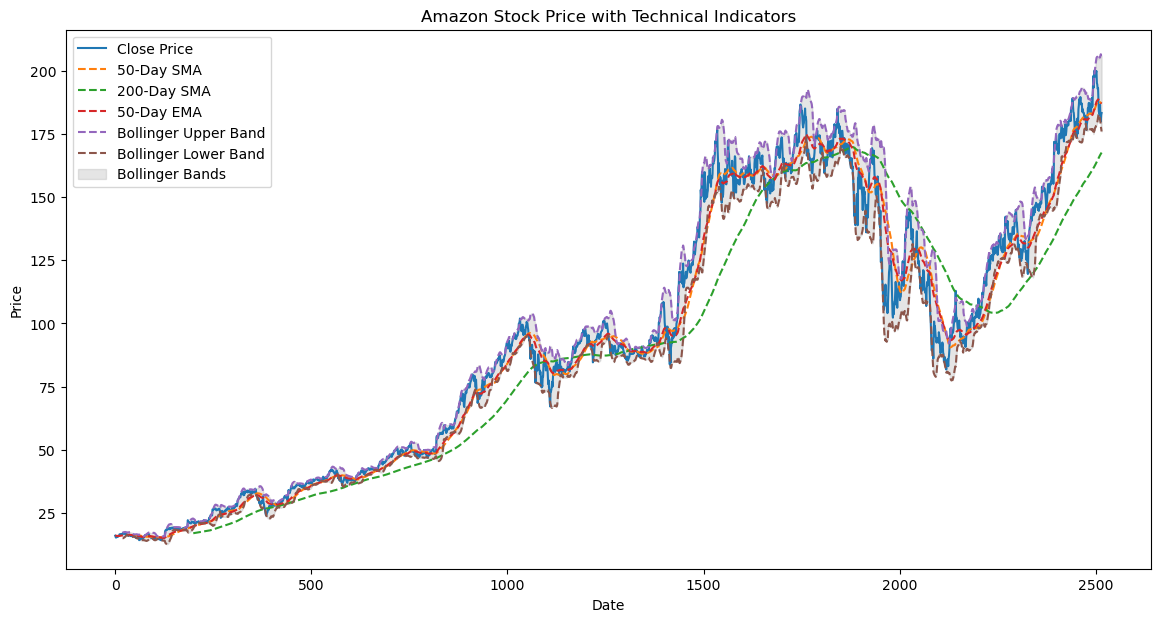

In [21]:
# Plot Close price along with SMA, EMA, and Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(amazon_TI_data['Close'], label='Close Price')
plt.plot(amazon_TI_data['SMA_50'], label='50-Day SMA', linestyle='--')
plt.plot(amazon_TI_data['SMA_200'], label='200-Day SMA', linestyle='--')
plt.plot(amazon_TI_data['EMA_50'], label='50-Day EMA', linestyle='--')
plt.plot(amazon_TI_data['BB_Upper'], label='Bollinger Upper Band', linestyle='--')
plt.plot(amazon_TI_data['BB_Lower'], label='Bollinger Lower Band', linestyle='--')
plt.fill_between(amazon_TI_data.index, amazon_TI_data['BB_Lower'], amazon_TI_data['BB_Upper'], color='gray', alpha=0.2, label = 'Bollinger Bands')
plt.title('Amazon Stock Price with Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [22]:
def plot_technical_indicators(amazon_TI_data, last_days):
    plt.figure(figsize=(14, 7), dpi=100)
    shape_0 = amazon_TI_data.shape[0]
    xmacd_ = shape_0-last_days
    
    amazon_TI_data = amazon_TI_data.iloc[-last_days:, :]
    x_ = range(3, amazon_TI_data.shape[0])
    x_ =list(amazon_TI_data.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(amazon_TI_data['SMA_50'],label='SMA 50', color='g',linestyle='--')
    plt.plot(amazon_TI_data['Close'],label='Closing Price', color='b')
    plt.plot(amazon_TI_data['SMA_200'],label='SMA 200', color='r',linestyle='--')
    plt.plot(amazon_TI_data['BB_Upper'],label='Upper Band', color='c')
    plt.plot(amazon_TI_data['BB_Lower'],label='Lower Band', color='c')
    plt.fill_between(x_, amazon_TI_data['BB_Lower'], amazon_TI_data['BB_Upper'], alpha=0.35)
    plt.title('Amazon Stock Price with Technical Indicators - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('Moving Average Convergence Divergence (MACD)')
    plt.plot(amazon_TI_data['MACD'], label='MACD', color='purple')
    plt.plot(amazon_TI_data['MACD_Signal'], label='Signal Line', linestyle='--', color='red')
    plt.hlines(10, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-10, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(amazon_TI_data['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

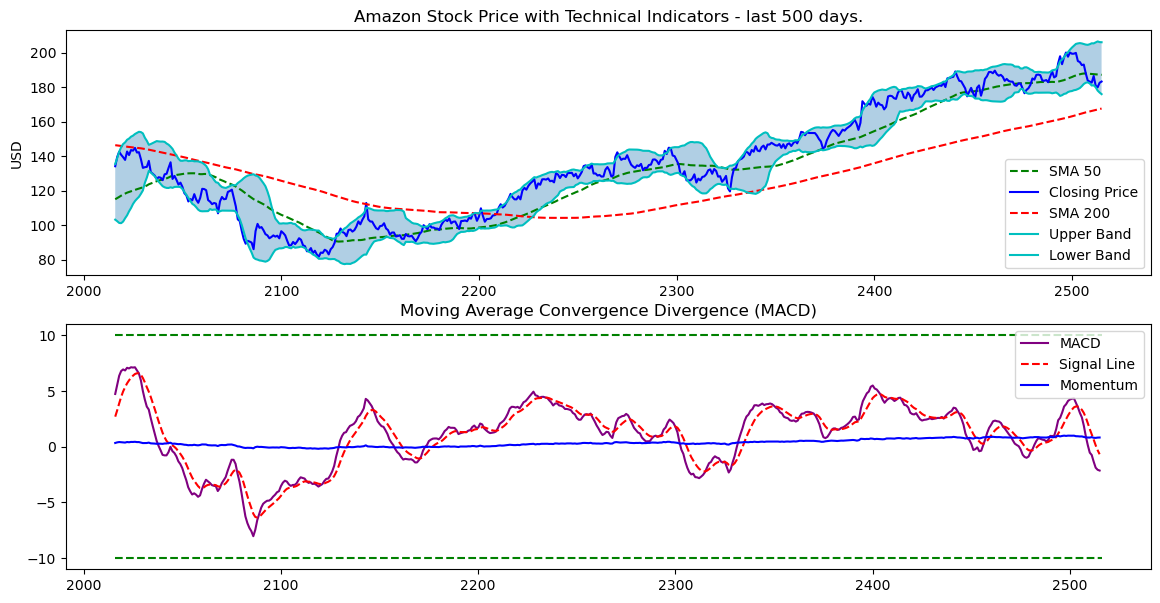

In [23]:
plot_technical_indicators(amazon_TI_data, 500)

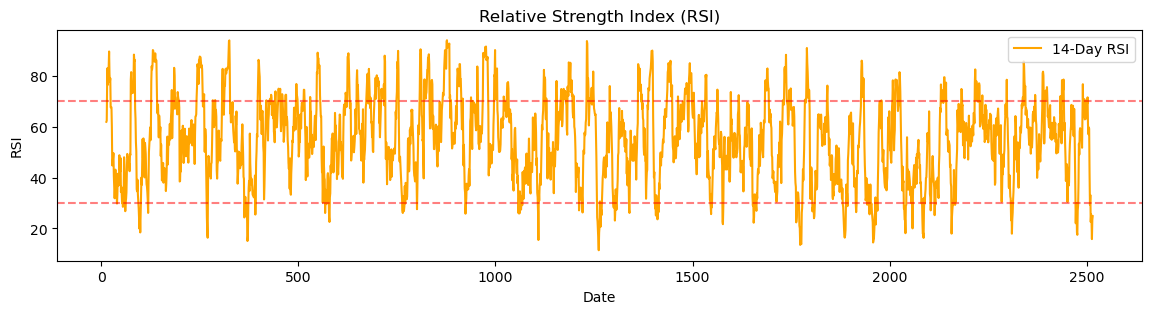

In [24]:
# Plot RSI
plt.figure(figsize=(14, 3))
plt.plot(amazon_data['RSI_14'], label='14-Day RSI', color='orange')
plt.axhline(30, linestyle='--', alpha=0.5, color='red')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

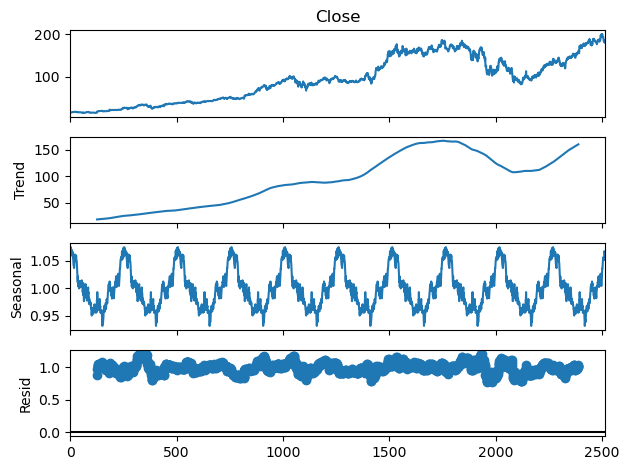

In [25]:
# Decompose the time series
result = seasonal_decompose(amazon_TI_data['Close'], model='multiplicative', period=252)
result.plot()
plt.show()

MODEL DEVELOPMENT

Time Series Analysis using Fourier series

In [26]:
data_FS = amazon_data[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FS['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

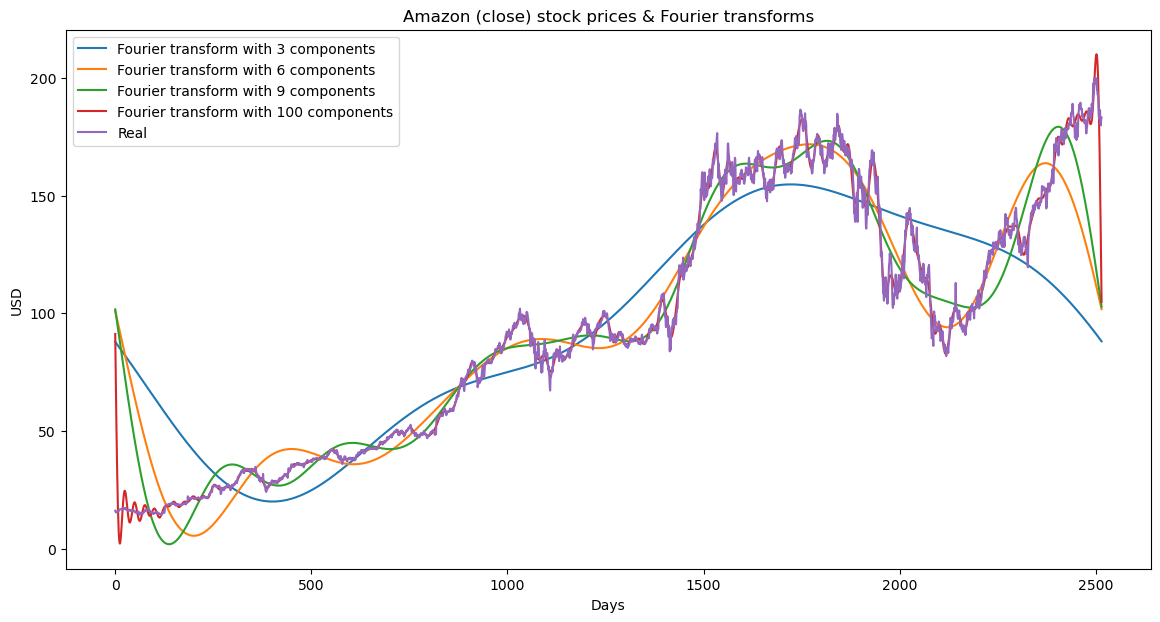

In [27]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FS['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Amazon (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

Fourier Transform uses many spectral components to try and train data. From time domain its converted to frequency domain and then calculated. After that it's reconverted into time domain where it's plotted. Fourier Transform as indicator helps to extract predominate cycle from a series of data

In [28]:
def get_fourier(amazon_data):
    data_FS = amazon_data[['Date', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FS['Close'].tolist()))
    close_fft = np.fft.ifft(close_fft)
    close_fft
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[100:-100]=0
    amazon_data['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    #dataset['absolute'] = dataset['Fourier'].apply(lambda x: np.abs(x))
    return amazon_data

In [29]:
amazon_TIF_data= get_fourier(amazon_data)

In [30]:
amazon_TIF_data.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_50,SMA_200,EMA_50,ema,MACD,MACD_Signal,BB_Mid,BB_Upper,BB_Lower,RSI_14,momentum,Fourier
0,2014-07-30,16.072500,16.136499,15.925000,16.125500,16.125500,79380000,NaN,NaN,16.125500,16.125500,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.838745,16.125500
1,2014-07-31,16.000500,16.034000,15.593000,15.649500,15.649500,103840000,NaN,NaN,16.106833,15.768500,-0.037972,-0.007594,NaN,NaN,NaN,NaN,-0.843505,15.649500
2,2014-08-01,15.684500,15.791500,15.229500,15.353000,15.353000,148830000,NaN,NaN,16.077271,15.480846,-0.090941,-0.024264,NaN,NaN,NaN,NaN,-0.846470,15.353000
3,2014-08-04,15.442000,15.809000,15.425000,15.682500,15.682500,84018000,NaN,NaN,16.061790,15.616962,-0.105120,-0.040435,NaN,NaN,NaN,NaN,-0.843175,15.682500
4,2014-08-05,15.665000,15.727500,15.503000,15.616000,15.616000,57042000,NaN,NaN,16.044308,15.616318,-0.120336,-0.056415,NaN,NaN,NaN,NaN,-0.843840,15.616000
5,2014-08-06,15.541500,15.789000,15.510000,15.694500,15.694500,45938000,NaN,NaN,16.030590,15.668511,-0.124624,-0.070057,NaN,NaN,NaN,NaN,-0.843055,15.694500
6,2014-08-07,15.760500,15.794000,15.482500,15.572500,15.572500,58712000,NaN,NaN,16.012626,15.604474,-0.136295,-0.083304,NaN,NaN,NaN,NaN,-0.844275,15.572500
7,2014-08-08,15.597000,15.866000,15.533000,15.840000,15.840000,54118000,NaN,NaN,16.005856,15.761515,-0.122547,-0.091153,NaN,NaN,NaN,NaN,-0.841600,15.840000
8,2014-08-11,15.924000,16.018999,15.844000,15.916500,15.916500,49372000,NaN,NaN,16.002352,15.864844,-0.104277,-0.093778,NaN,NaN,NaN,NaN,-0.840835,15.916500
9,2014-08-12,15.944500,16.065500,15.847500,15.966000,15.966000,38316000,NaN,NaN,16.000926,15.932282,-0.084825,-0.091987,NaN,NaN,NaN,NaN,-0.840340,15.966000


In [31]:
from collections import deque

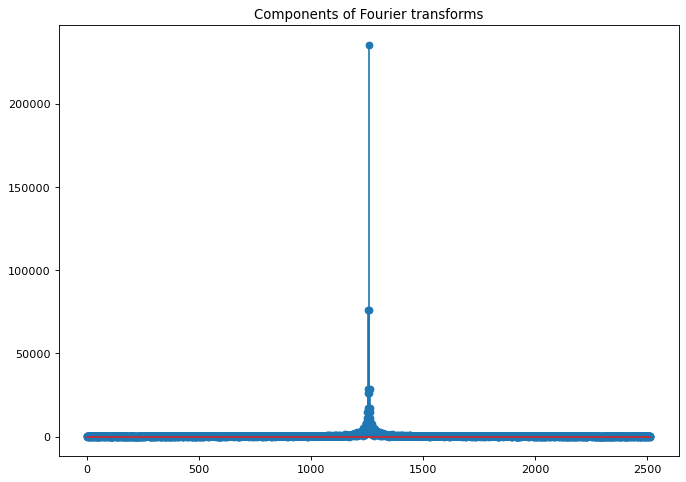

In [32]:
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Components of Fourier transforms')
plt.show()

ARIMA Model: Use AutoRegressive Integrated Moving Average for forecasting.

Identify parameters (p, d, q) using ACF and PACF plots.

Fit the ARIMA model to the data.

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

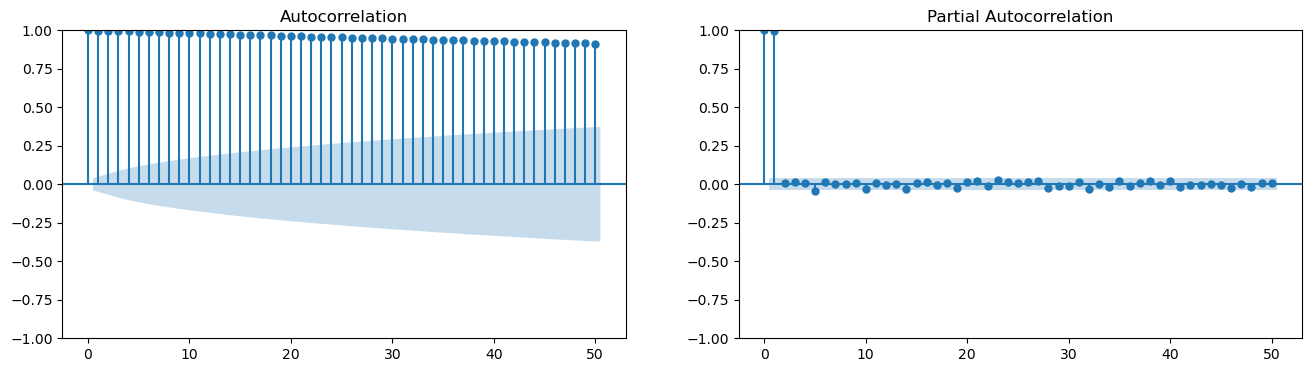

In [34]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(amazon_TI_data['Close'], lags=50, ax=axes[0])
plot_pacf(amazon_TI_data['Close'], lags=50, ax=axes[1])
plt.show()

In [35]:
import statsmodels.api as smapi

series = amazon_TI_data['Close']
model = smapi.tsa.arima.ARIMA(amazon_TI_data['Close'], order=(5, 1, 5))
result = model.fit()

In [36]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2516
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -5548.703
Date:                Mon, 05 Aug 2024   AIC                          11119.407
Time:                        12:13:50   BIC                          11183.537
Sample:                             0   HQIC                         11142.682
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0489      0.072      0.680      0.497      -0.092       0.190
ar.L2          0.3023      0.070      4.328      0.000       0.165       0.439
ar.L3         -0.3204      0.062     -5.147      0.0

SUMMARY OF THE ARIMA MODEL

A good starting point for the AR parameter of the model may be 5

From the summary, we can see that most P-values are greater than 0.05 other than the last two.

The difference between AIC and BIC is low so this indicates this is a good model

Running the example, we can see that there is a positive correlation with the first 0-to-500 lags that is perhaps significant for the first 250 lags in the autocorrelation below

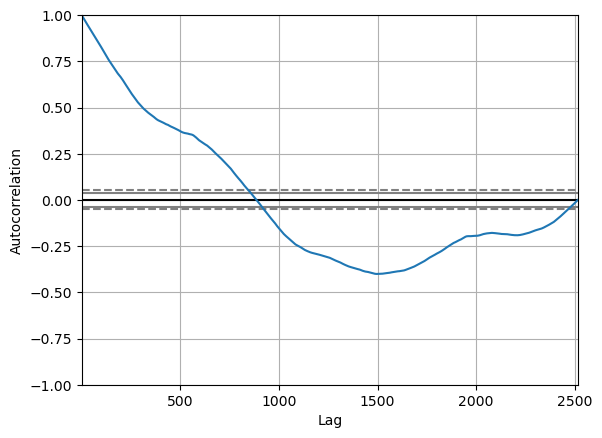

<Figure size 800x560 with 0 Axes>

In [37]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

Explanation of the ARIMA Model:

In [38]:
from sklearn.metrics import mean_squared_error

In [39]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    result = model.fit()
    output = result.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

amazon_TI_data['ARIMA'] = pd.DataFrame(predictions)

In [40]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 9.295


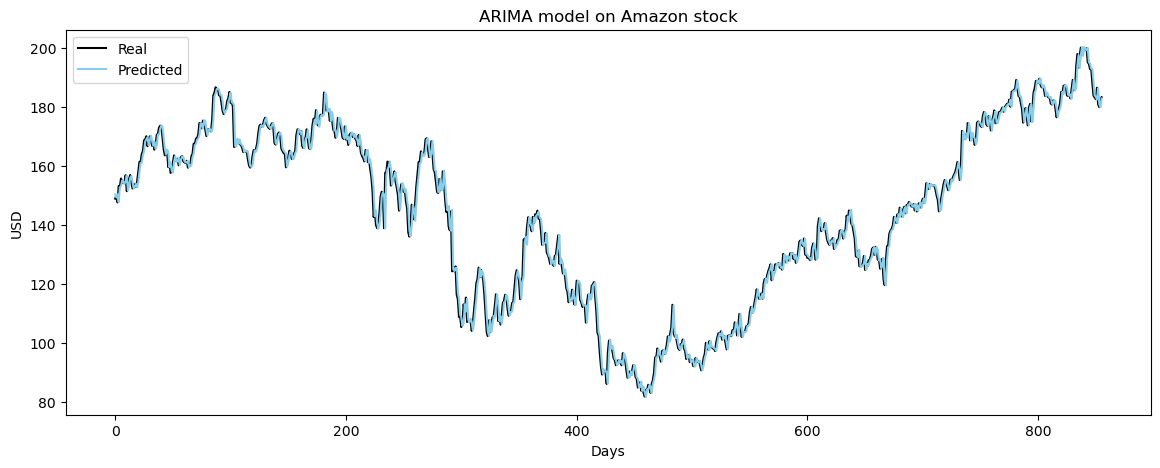

In [41]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(14, 5), dpi=100)
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='skyblue', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARIMA model on Amazon stock')
plt.legend()
plt.show()

In [42]:
amazon_TI_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_50,SMA_200,EMA_50,ema,MACD,MACD_Signal,BB_Mid,BB_Upper,BB_Lower,RSI_14,momentum,Fourier,ARIMA
0,2014-07-30,16.0725,16.136499,15.9250,16.1255,16.1255,79380000,NaN,NaN,16.125500,16.125500,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.838745,16.1255,150.261212
1,2014-07-31,16.0005,16.034000,15.5930,15.6495,15.6495,103840000,NaN,NaN,16.106833,15.768500,-0.037972,-0.007594,NaN,NaN,NaN,NaN,-0.843505,15.6495,149.248341
2,2014-08-01,15.6845,15.791500,15.2295,15.3530,15.3530,148830000,NaN,NaN,16.077271,15.480846,-0.090941,-0.024264,NaN,NaN,NaN,NaN,-0.846470,15.3530,150.331061
3,2014-08-04,15.4420,15.809000,15.4250,15.6825,15.6825,84018000,NaN,NaN,16.061790,15.616962,-0.105120,-0.040435,NaN,NaN,NaN,NaN,-0.843175,15.6825,147.719491
4,2014-08-05,15.6650,15.727500,15.5030,15.6160,15.6160,57042000,NaN,NaN,16.044308,15.616318,-0.120336,-0.056415,NaN,NaN,NaN,NaN,-0.843840,15.6160,152.693499


SARIMA Model: Seasonal ARIMA for capturing seasonality.

Identify seasonal parameters (P, D, Q, s).

Fit the SARIMA model to the data.

In [86]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [87]:
# Fit the SARIMA model
sarima_model = SARIMAX(train_data, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()

In [88]:
print(sarima_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 2012
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood                6140.301
Date:                              Mon, 05 Aug 2024   AIC                         -12264.603
Time:                                      12:33:01   BIC                         -12219.799
Sample:                                           0   HQIC                        -12248.151
                                             - 2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0217      0.013      1.614      0.107      -0.005       0.048
ar.L2          0.01

LSTM Model: Use Long Short-Term Memory networks for deep learning-based forecasting.

We'll try to predict the closing prices using 1 feature Open(It has highest correlation to closing price) initially and then using multiple features(use some sort of one hot encoding) and then try to get a output.

Prepare the data for LSTM (scaling, reshaping).

Build and train the LSTM model using TensorFlow or Keras.

In [43]:
pip install --upgrade keras

Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten  
from keras.layers import Activation

In [46]:
import tensorflow as tf
tf.random.set_seed(7)

In [47]:
amazon_TI_data.values
amazon_TI_data.astype

<bound method NDFrame.astype of            Date        Open        High         Low       Close   Adj Close  \
0    2014-07-30   16.072500   16.136499   15.925000   16.125500   16.125500   
1    2014-07-31   16.000500   16.034000   15.593000   15.649500   15.649500   
2    2014-08-01   15.684500   15.791500   15.229500   15.353000   15.353000   
3    2014-08-04   15.442000   15.809000   15.425000   15.682500   15.682500   
4    2014-08-05   15.665000   15.727500   15.503000   15.616000   15.616000   
...         ...         ...         ...         ...         ...         ...   
2511 2024-07-23  184.100006  189.389999  183.559998  186.410004  186.410004   
2512 2024-07-24  183.199997  185.449997  180.410004  180.830002  180.830002   
2513 2024-07-25  182.910004  183.899994  176.800003  179.850006  179.850006   
2514 2024-07-26  180.389999  183.190002  180.240005  182.500000  182.500000   
2515 2024-07-29  183.839996  184.750000  182.380005  183.199997  183.199997   

         Volume    

In [48]:
# Convert 'Date' column to datetime format and sort by date
amazon_TI_data['Date'] = pd.to_datetime(amazon_TI_data['Date'])
amazon_TI_data.sort_values('Date', inplace=True)

In [49]:
# Select the 'Close' column and convert to a numpy array
close_prices = amazon_TI_data['Close'].values.reshape(-1, 1)

In [50]:
# Normalize the 'Close' values
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices = scaler.fit_transform(close_prices)

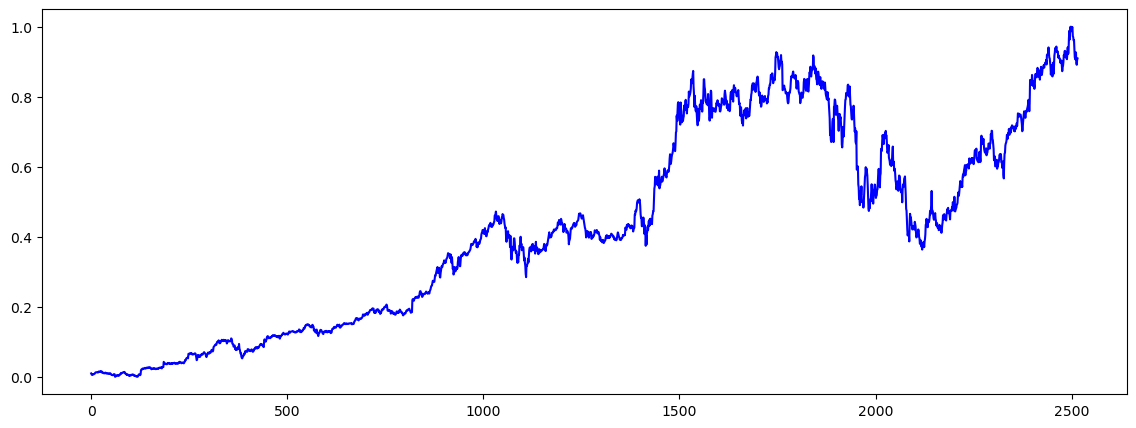

In [51]:
#Ploting it
plt.figure(figsize=(14, 5))
plt.plot(close_prices, color='blue')
plt.show()

In [52]:
# Function to create sequences for training
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [53]:
# Define sequence length
seq_length = 60

# Create sequences
X, y = create_sequences(close_prices, seq_length)

In [54]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [55]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [56]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [57]:
# Train the model
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.0017 - val_loss: 0.0202
Epoch 2/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0092 - val_loss: 0.0069
Epoch 3/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0151 - val_loss: 0.0071
Epoch 4/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0103 - val_loss: 0.0079
Epoch 5/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0031 - val_loss: 0.0071
Epoch 6/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 7/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 7.8830e-04 - val_loss: 0.0079
Epoch 8/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 8.4994e-04 - val_loss: 0.0099
Epoch 9/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0011 - val_loss: 0.0103
Epoch 10/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0013 - val_loss: 0.0140
Epoch 11/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0019 - val_loss: 0.0156
Epoch 12/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - 

In [58]:
# Make predictions
predicted_close = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [59]:
# Evaluate the model
mse = np.mean((predicted_close - y_test) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00462542609460952


In [60]:
# Inverse transform the predictions and actual values
predicted_close = scaler.inverse_transform(predicted_close)
actual_close = scaler.inverse_transform(y_test)

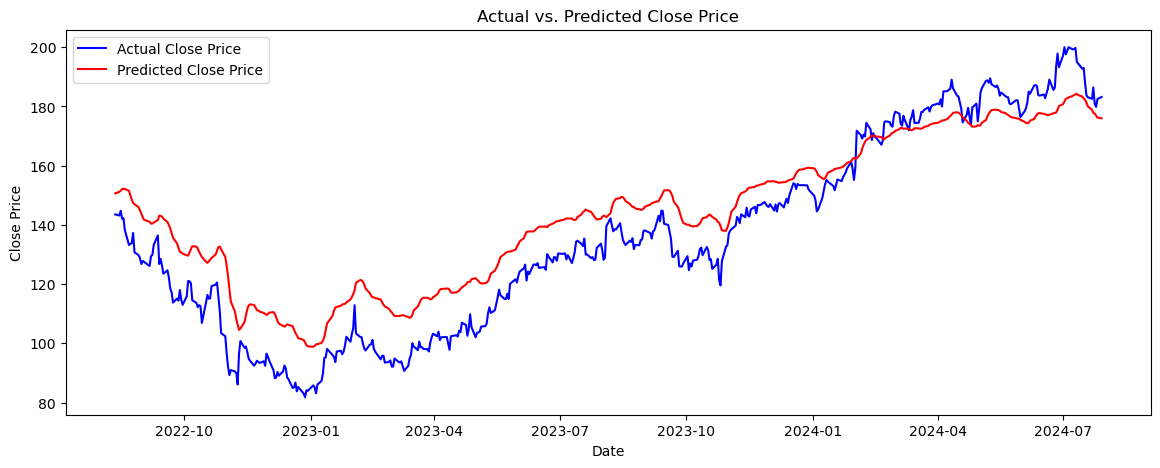

In [61]:
# Plot actual vs. predicted values
plt.figure(figsize=(14, 5))
plt.plot(amazon_TI_data['Date'][-len(actual_close):], actual_close, color='blue', label='Actual Close Price')
plt.plot(amazon_TI_data['Date'][-len(predicted_close):], predicted_close, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.show()

In [62]:
# Prepare and normalize the data for LSTM
lstm_data = amazon_TI_data[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
lstm_data = scaler.fit_transform(lstm_data)

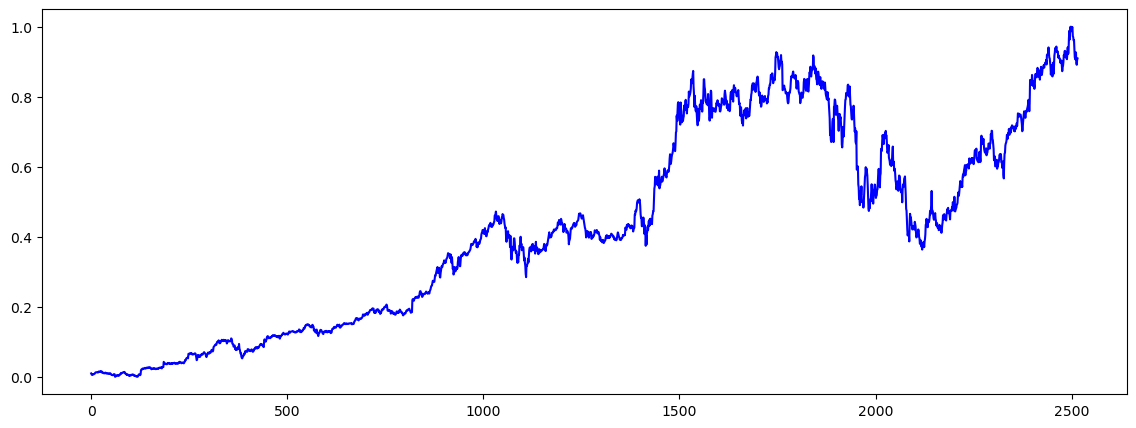

In [63]:
#Ploting it
plt.figure(figsize=(14,5))
plt.plot(lstm_data, color='blue')
plt.show()

In [64]:
# Create training and testing datasets
train_size = int(len(lstm_data) * 0.8)
test_size = len(lstm_data) - train_size
train_data, test_data = lstm_data[0:train_size], lstm_data[test_size:]

In [65]:
print(len(test_data), len(train_data))

2012 2012


In [66]:
# Create datasets for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [67]:
# reshape into X=t and Y=t+1
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [68]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [69]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_train.shape[0], 1, X_test.shape[1]))

In [70]:
import time #helper libraries

In [71]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('relu'))

start = time.time()
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
print ('compilation time : ', time.time() - start)

compilation time :  0.0019953250885009766


In [72]:
model.fit(X_train, y_train, batch_size=32, epochs=80, validation_split=0.05)

Epoch 1/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1638 - mae: 0.3049 - val_loss: 0.0202 - val_mae: 0.1208
Epoch 2/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0341 - mae: 0.1589 - val_loss: 0.0026 - val_mae: 0.0429
Epoch 3/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - mae: 0.0684 - val_loss: 0.0016 - val_mae: 0.0343
Epoch 4/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - mae: 0.0376 - val_loss: 9.2060e-04 - val_mae: 0.0252
Epoch 5/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - mae: 0.0390 - val_loss: 8.6422e-04 - val_mae: 0.0243
Epoch 6/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0012 - val_mae: 0.0294
Epoch 7/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mae: 0.0347 - val_loss: 9.4826e-04 - val_mae: 0.0254
Epoch 8/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - mae: 0.0356 - val_loss: 7.5017e-04 - val_mae: 0.0222
Epoch 9/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - los

In [73]:
predicted_stateful = model.predict(X_test)

# Inverse transform the predictions and actual values
predicted_stateful = scaler.inverse_transform(predicted_stateful)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [74]:
# Evaluate the model
mse = np.mean((predicted_close - y_test) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 21013.187455850548


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


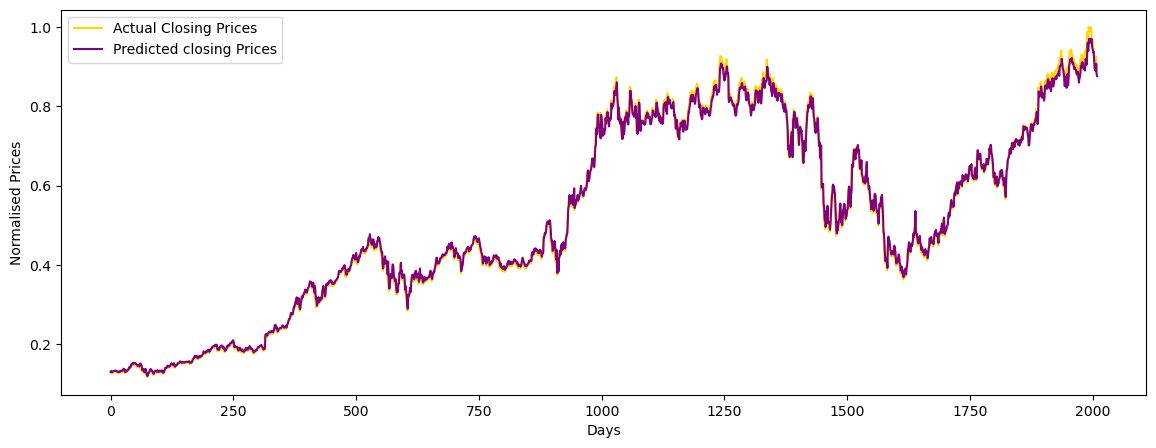

In [75]:
predicted_stateful = model.predict(X_test)
plt.figure(figsize = (14,5))
plt.plot(y_test, color = 'gold',label = 'Actual Closing Prices')
plt.plot(predicted_stateful.flatten(), color = 'purple', label  = 'Predicted closing Prices')
plt.xlabel('Days')
plt.ylabel('Normalised Prices')
plt.legend(loc='best')
plt.show()

FORECASTING

Use the best-performing model to forecast future stock prices.

Plot the forecasted values against the actual values for visualization.

In [76]:
# Forecasting the next 30 days
last_sequence = close_prices[-seq_length:]
forecast = []

In [77]:
for _ in range(30):
    next_prediction = model.predict(last_sequence.reshape(1, seq_length, 1))
    forecast.append(next_prediction[0, 0])
    last_sequence = np.append(last_sequence[1:], next_prediction, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

In [78]:
# Inverse transform the forecasted values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

In [79]:
# Prepare the dates for the forecast
last_date = amazon_TI_data['Date'].iloc[-1]
forecast_dates = pd.date_range(last_date, periods=31)[1:]  # Skip the last_date to start from the next day

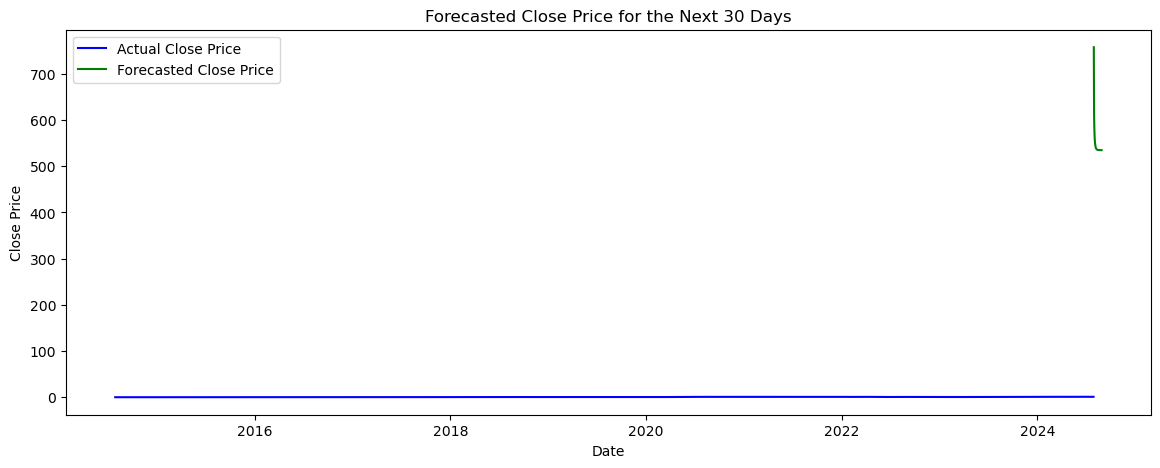

In [80]:
# Plot the forecasted values
plt.figure(figsize=(14, 5))
plt.plot(amazon_TI_data['Date'], close_prices, color='blue', label='Actual Close Price')
plt.plot(forecast_dates, forecast, color='green', label='Forecasted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Forecasted Close Price for the Next 30 Days')
plt.legend()
plt.show()

In [81]:
# Forecast future prices using the best-performing model (e.g., LSTM)
future_steps = 30
future_inputs = lstm_data[-time_step:]
future_inputs = future_inputs.reshape(1, time_step, 1)

In [82]:
# Predict future stock prices
future_inputs = X_test[-1:]
future_prices = []

for i in range(10):  # Predict the next 10 days
    future_price = model.predict(future_inputs)
    future_prices.append(future_price[0, 0])
# Update future_inputs to include the new prediction
    future_price_scaled = future_price.reshape(1, 1, 1)
    future_inputs = np.append(future_inputs[:, 1:, :], future_price_scaled, axis=1)    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [83]:
# Inverse transform future prices
future_prices = np.array(future_prices).reshape(-1, 1)
future_prices = scaler.inverse_transform(future_prices)

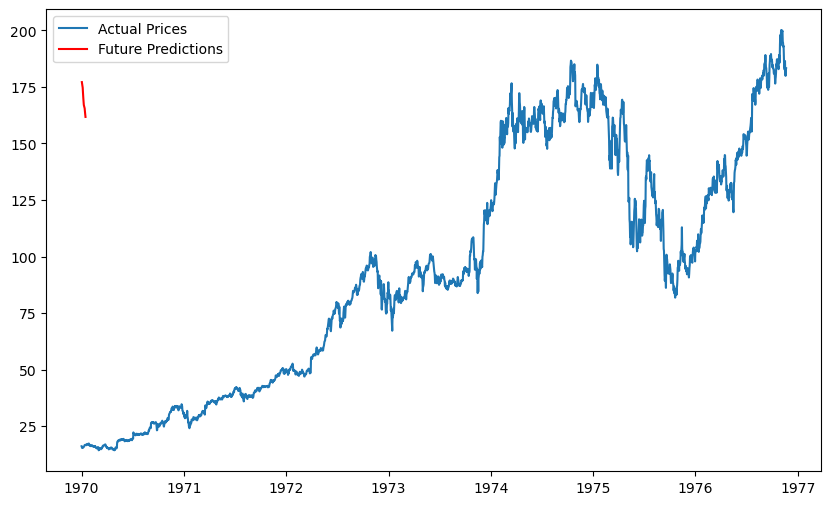

In [84]:
# Plot the future predictions
future_dates = pd.date_range(start=amazon_TI_data.index[-1], periods=11, freq='B')[1:]
plt.figure(figsize=(10, 6))
plt.plot(amazon_TI_data.index, scaler.inverse_transform(lstm_data), label='Actual Prices')
plt.plot(future_dates, future_prices, label='Future Predictions', color='red')
plt.legend()
plt.show()

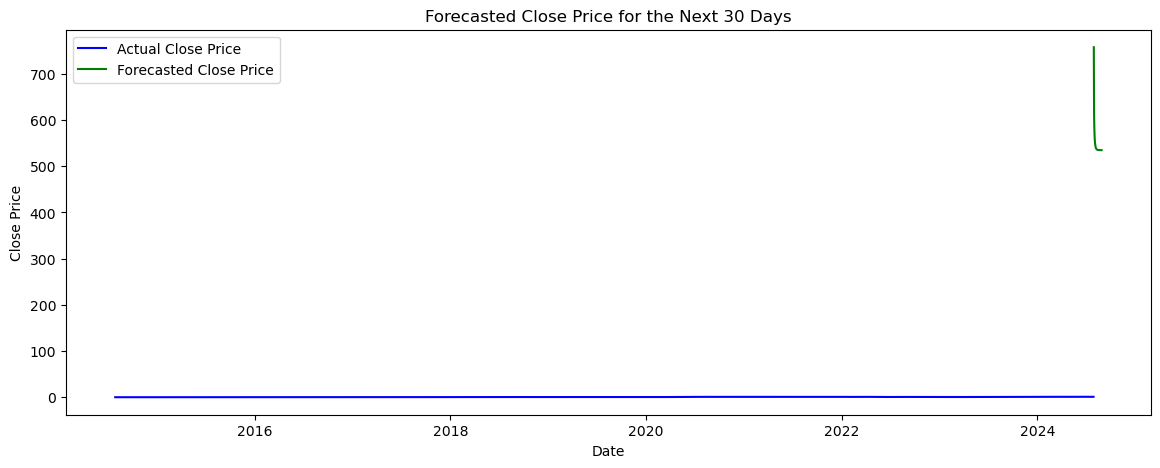

In [85]:
# Plot the forecasted values
plt.figure(figsize=(14, 5))
plt.plot(amazon_TI_data['Date'], lstm_data, color='blue', label='Actual Close Price')
plt.plot(forecast_dates, forecast, color='green', label='Forecasted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Forecasted Close Price for the Next 30 Days')
plt.legend()
plt.show()